## Tropical cyclone impact forecast

This jupyter script runs the tropical cyclone (TC) ensemble impact forecast using [CLIMADA](https://wcr.ethz.ch/research/climada.html) platform. The TC forecast is retrieved from the European Centre for Medium-Range Weather Forecasts (ECMWF) forecast products. [Click here](https://www.ecmwf.int/en/forecasts/charts/tcyclone/) to see the latest TC activity.

**Pre-requisites** 

Users need to specity the name of the TCs in `TC_NAME` and the target country `COUNTRY_ISO3` in ISO3 format to run this script, for the latest storm activities please refer to [ECMWF latest TC activities](https://www.ecmwf.int/en/forecasts/charts/tcyclone/).

Also, there should be a `./data/` directory which store the centroids file in `.hdf5` format, and a `./results/` directory for storing the outputs.

**Outputs**

The output of this script is an excel summary table table that gives the number of affected people in the country by TC wind speed exceeding certain thresholds (equivalent to category 1-5 hurricane) of each ensemble tracks (in total 51), and the average number of all tracks (1st part). The 2nd part of the impact calculation estimates the number of potential displacement, following [Kam et al. (2023)](https://www.researchgate.net/publication/376398866_Impact-Based_Forecasting_of_Tropical_Cyclone-Related_Human_Displacement_to_Support_Anticipatory_Action). 

Note that some forecast does not give a full set of 51 tracks, since not every forecast simulations predict well-formed TC. However, the average number shall still be calsulated as sum of all prediced number of affected people divided by 51.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

#### User's specification for running the impact forecast for selected tropical cyclone and country at setected forecast time.

`TC_NAME`: The standard WMO tropical cyclone name. <br>
`COUNTRY_ISO3`: The ISO alpha-3 code of the country. <br>
`FORECAST_TIME`: In the format of 'yyyymmddhhmmss', the the time when the forecast is initiated. `None` for retrieving the latest available forecast. The forecast is updated everyday at 00 and 12 UTC, user may expect a few hours delay until the ECMWF upload their data to the server.

In [2]:
TC_NAME = 'BERYL' # Desired TC name in capital letters
COUNTRY_ISO3 = 'USA' # Desired country in ISO alpha3

FORECAST_TIME = '20240708000000' # Specified the forecast datetime, None for the latest forecast. 
                     # In the format of 'yyyymmddhhmmss'. e.g. '20211201000000', available at every 00 and 12 UTC
# Uncomment for the latest forecast
# FORECAST_TIME = None

#### Define directories for storing data and results

User may explicitly define the directories which store the data and the output results

`DATA_DIR`: Stores the data that is used for the script, it should contain `'earth_centroids_150asland_1800asoceans_distcoast_region.hdf5'`. Default `'./data/'`.<br>
`SAVE_DIR`: Stores the output results. Default `'./results/'`.

In [3]:
# Directories
DATA_DIR = './data/'
SAVE_DIR = './results/'

#### Constants

Do not change this section

In [15]:
CENT_PATH = DATA_DIR +'earth_centroids_150asland_1800asoceans_distcoast_region.hdf5'

N_ENS = 51 # total number of ensemble members
# Threshold for the impact function in m/s, respective to cat. 1-5 hurricanes
IMPF_THRESHOLD_LIST = [32.92, 42.70, 49.38, 58.13, 70.48]
# categories
IMPF_CAT = ['Cat. 1', 'Cat. 2', 'Cat. 3', 'Cat. 4', 'Cat. 5']

ISO3_TO_BASINS = {'NA1': ['AIA', 'ATG', 'ARG', 'ABW', 'BHS', 'BRB', 'BLZ', 'BMU',
                         'BOL', 'CPV', 'CYM', 'CHL', 'COL', 'CRI', 'CUB', 'DMA',
                         'DOM', 'ECU', 'SLV', 'FLK', 'GUF', 'GRD', 'GLP', 'GTM',
                         'GUY', 'HTI', 'HND', 'JAM', 'MTQ', 'MEX', 'MSR', 'NIC',
                         'PAN', 'PRY', 'PER', 'PRI', 'SHN', 'KNA', 'LCA', 'VCT',
                         'SXM', 'SUR', 'TTO', 'TCA', 'URY', 'VEN', 'VGB', 'VIR'],
                 'NA2': ['CAN', 'USA'],
                 'NI': ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'DJI', 'ERI',
                        'ETH', 'GEO', 'IND', 'IRN', 'IRQ', 'ISR', 'JOR', 'KAZ',
                        'KWT', 'KGZ', 'LBN', 'MDV', 'MNG', 'MMR', 'NPL', 'OMN',
                        'PAK', 'QAT', 'SAU', 'SOM', 'LKA', 'SYR', 'TJK', 'TKM',
                        'UGA', 'ARE', 'UZB', 'YEM'],
                'OC1': ['ASM', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 'MHL', 'FSM', 
                        'NRU', 'NCL', 'NIU', 'NFK', 'MNP', 'PLW', 'PNG', 'PCN', 
                        'WSM', 'SLB', 'TLS', 'TKL', 'TON', 'TUV', 'VUT', 'WLF'],
                'OC2': ['AUS', 'NZL'],
                'SI': ['COM', 'COD', 'SWZ', 'MDG', 'MWI', 'MLI', 'MUS', 'MOZ',
                        'ZAF', 'TZA', 'ZWE'],
                'WP1': ['KHM', 'IDN', 'LAO', 'MYS', 'THA', 'VNM'],
                'WP2': ['PHL'],
                'WP3': ['CHN'],
                'WP4': ['HKG', 'JPN', 'KOR', 'MAC', 'TWN'],
                'ROW': ['ALB', 'DZA', 'AND', 'AGO', 'ATA', 'AUT', 'BLR', 'BEL',
                         'BEN', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN',
                         'BGR', 'BFA', 'BDI', 'CMR', 'CAF', 'TCD', 'CXR', 'CCK',
                         'COG', 'HRV', 'CUW', 'CYP', 'CZE', 'CIV', 'DNK', 'EGY',
                         'GNQ', 'EST', 'FRO', 'FIN', 'FRA', 'ATF', 'GAB', 'GMB',
                         'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GGY', 'GIN', 'GNB',
                         'HMD', 'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY',
                         'KEN', 'PRK', 'XKX', 'LVA', 'LSO', 'LBR', 'LBY', 'LIE',
                         'LTU', 'LUX', 'MLT', 'MRT', 'MYT', 'MDA', 'MCO', 'MNE',
                         'MAR', 'NAM', 'NLD', 'NER', 'NGA', 'MKD', 'NOR', 'PSE',
                         'POL', 'PRT', 'ROU', 'RUS', 'RWA', 'REU', 'BLM', 'MAF',
                         'SPM', 'SMR', 'STP', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP',
                         'SVK', 'SVN', 'SGS', 'SSD', 'ESP', 'SDN', 'SJM', 'SWE',
                         'CHE', 'TGO', 'TUN', 'TUR', 'UKR', 'GBR', 'UMI', 'ESH',
                         'ZMB', 'ALA']}

IMPF_V_HALF_LIST = {'NA1': 51.6,
                    'NA2': 84.1,
                    'NI': 41.3,
                    'OC1': 44.3,
                    'OC2': 47.4,
                    'SI': 40.8,
                    'WP1': 42.2,
                    'WP2': 46.7,
                    'WP3': 35.7,
                    'WP4': 93.1}

#### Functions

In [5]:
import numpy as np

from climada.util.coordinates import latlon_bounds
from climada.entity import ImpactFunc, ImpactFuncSet, ImpfTropCyclone

def extent_buffer(extent, buffer=5):
    extent = latlon_bounds(np.array([extent[2], extent[3]]), np.array([extent[0], extent[1]]), buffer=buffer)
    
    return (extent[0], extent[2], extent[1], extent[3])

def step_impf(threshold=49.38):
    """
    Set the step function set
    Argument:
        threshold (float): threshold for the step function. default 32.93m/s (64knots)
    """
    step_impf_TC = ImpactFunc.from_step_impf([0,threshold,100],
                                            haz_type="TC")
    step_impf_TC.intensity_unit = 'm/s'

    step_impfSet_TC = ImpactFuncSet()
    step_impfSet_TC.append(step_impf_TC)
    
    return step_impfSet_TC

def displacement_impf(v_half=32.93):
    """
    Set the displacement function
    Argument:
        v_half (float): v_half for the sigmoid function from Emanuel (2011)
    """
    impf_tc = ImpfTropCyclone.from_emanuel_usa(v_thresh=25.7,
                                               v_half=v_half,
                                               scale=1.)
    impf_tc.haz_type = "TC"
    impf_tc.id = 1
    impf_tc.name = 'TC impf v_half ' +str(v_half)  +' m/s)'
    impf_tc.intensity_unit = 'm/s'

    displacement_impf_set = ImpactFuncSet()
    displacement_impf_set.append(impf_tc)
    
    return displacement_impf_set

def get_v_half(country):
    """
    Get v_half according to selected country (country_iso3)
    Argument:
        country (string): selected country (variable is "country_iso3")
    """
    # Get basin in which country_iso3 lies
    basin = [key
            for key, list_of_values in ISO3_TO_BASINS.items()
            if country in list_of_values]
    
    # Get best v_half corresponding to basin
    v_half = IMPF_V_HALF_LIST[basin[0]]
    
    return v_half

#### Retrieving the TC tracks forecast from the ECMWF server

The ECMWF ensemble forecast tracks give the information of the central pressure, locational and time information. The predicted wind speed is calculated in the next section.

Processing: 100%|██████████| 36/36 [00:04<00:00,  8.91 files/s]


<GeoAxes: >

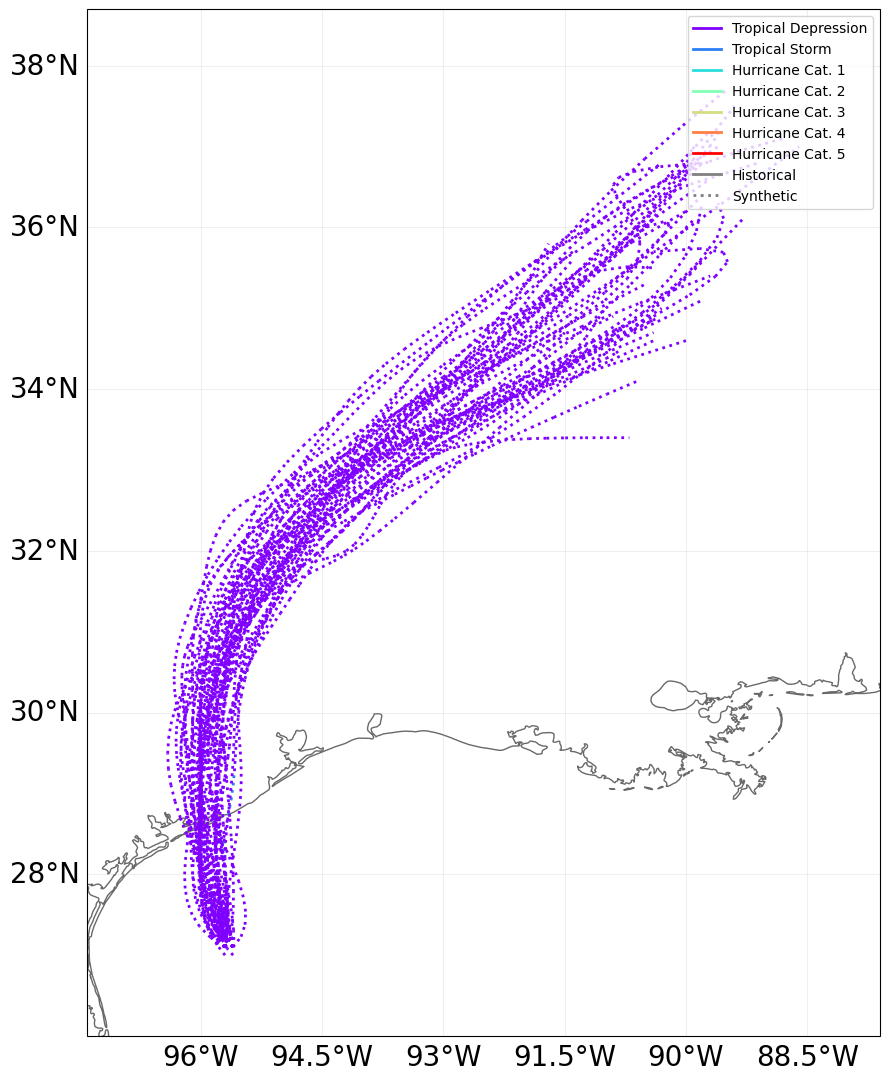

In [6]:
from climada_petals.hazard import TCForecast

# Fetch the latest forecast or at desired datetime for all tracks
fcast_all = TCForecast()
fcast_all.fetch_ecmwf(remote_dir=FORECAST_TIME)

# Select the desired tracks
tr_fcast = fcast_all.subset({'name':TC_NAME,
                             'is_ensemble': True})
tr_fcast.equal_timestep(1) # interpolate the track to 1 hour interval

# get the extent of the tracks
extent = tr_fcast.get_extent()
extent_buffered = extent_buffer(extent, buffer=5)

tracks_list = ['track ' +str(tr.ensemble_number) for tr in tr_fcast.data]

time_arr = np.datetime_as_string(tr_fcast.data[0].time, unit='h')
time_print = time_arr[0]

# Uncomment to plot all the forecasted tracks of the storm
tr_fcast.plot()

#### Compute the wind field of the tracks

This section compute the predicted windfield of the tracks at a resolution of ~5km on land and ~50km on sea.

**WARNING: This section may take longer time to complete**

<GeoAxes: title={'center': 'TC max intensity at each point'}>

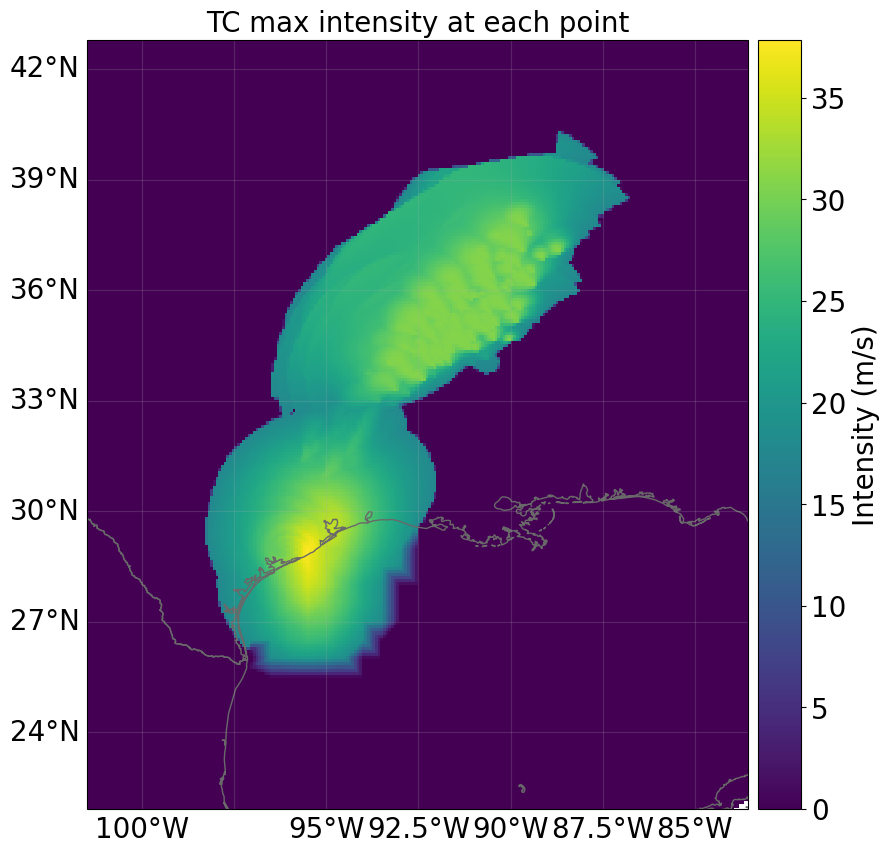

In [7]:
from climada.hazard import TropCyclone, Centroids
import numpy as np

centroids_global = Centroids.from_hdf5(CENT_PATH)
centroids_sel = centroids_global.select(extent=extent_buffered)

tc_fcast = TropCyclone.from_tracks(tr_fcast, centroids_sel)

# plot maximum wind speed at each points
tc_fcast.plot_intensity(0)

#### Get the population information

This section retrieve the population counts of the selected country at a resolution of ~1km. 

In [8]:
from climada.entity import LitPop

exp = LitPop.from_population(countries=COUNTRY_ISO3, reference_year=2020)
exp.assign_centroids(tc_fcast, threshold=5)

# Uncomment to plot the population count layer
# exp.plot_scatter()

2024-07-09 15:15:34,192 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 5km for 12522665 coordinates.


#### Impact calculation (People exposed to different categories of TCs)

This section calculate the number of affected people by different threshold of wind speed for each tracks.

In [9]:
from climada.engine import ImpactCalc

dic_results = dict()
dic_results['track no.'] = tracks_list

dic_avg = dict()
dic_avg['track no.'] = ['average']

# calculate impact for each threshold
for idx_cat, cat_name in enumerate(IMPF_CAT):
    tc_step_impf = step_impf(threshold=IMPF_THRESHOLD_LIST[idx_cat])
    
    imp_tc = ImpactCalc(exp, tc_step_impf, tc_fcast).impact()
    
    dic_results[cat_name] = imp_tc.at_event
    dic_avg[cat_name] = imp_tc.at_event.sum()/N_ENS

2024-07-09 15:16:03,196 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.
2024-07-09 15:16:33,085 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.
2024-07-09 15:17:01,413 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.
2024-07-09 15:17:29,854 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.
2024-07-09 15:17:58,107 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.


#### Make summary table for the results

In [10]:
import pandas as pd

# make summary table
df_results = pd.DataFrame.from_dict(dic_results)
df_results.set_index('track no.', inplace=True)

df_avg = pd.DataFrame.from_dict(dic_avg)
df_avg.set_index('track no.', inplace=True)

df_results = pd.concat([df_avg, df_results])

# print the summary table
df_results

,Cat. 1,Cat. 2,Cat. 3,Cat. 4,Cat. 5
track no.,,,,,
average,9.692918e+04,0.0,0.0,0.0,0.0
track 1,0.000000e+00,0.0,0.0,0.0,0.0
track 2,0.000000e+00,0.0,0.0,0.0,0.0
track 3,0.000000e+00,0.0,0.0,0.0,0.0
track 4,1.526531e+03,0.0,0.0,0.0,0.0
track 5,0.000000e+00,0.0,0.0,0.0,0.0
track 6,0.000000e+00,0.0,0.0,0.0,0.0
track 7,0.000000e+00,0.0,0.0,0.0,0.0
track 8,0.000000e+00,0.0,0.0,0.0,0.0


#### Save the summary table to excel

In [11]:
# save the summary table to excel 
df_results.to_excel(SAVE_DIR +'summary_forecast_TC_cat_exposed_' +TC_NAME +'_' +COUNTRY_ISO3 +'_' +time_print +'.xlsx')

#### Impact calculation (No. of displacement)

This section calculate the number of displacement.

In [12]:
dic_results_dis = dict()
dic_results_dis['track no.'] = tracks_list

dic_avg_dis = dict()
dic_avg_dis['track no.'] = ['average']

tc_displacement_impf = displacement_impf(v_half=get_v_half(COUNTRY_ISO3))

imp_displacement_tc = ImpactCalc(exp, tc_displacement_impf, tc_fcast).impact()
    
dic_results_dis["Displacement"] = imp_displacement_tc.at_event
dic_avg_dis["Displacement"] = imp_displacement_tc.at_event.sum()/N_ENS

2024-07-09 15:18:26,367 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 11960242 coordinates.


In [13]:
# make summary table
df_results_dis = pd.DataFrame.from_dict(dic_results_dis)
df_results_dis.set_index('track no.', inplace=True)

df_avg_dis = pd.DataFrame.from_dict(dic_avg_dis)
df_avg_dis.set_index('track no.', inplace=True)

df_results_dis = pd.concat([df_avg_dis, df_results_dis])

# print the summary table
df_results_dis

,Displacement
track no.,
average,2507.721540
track 1,3690.200139
track 2,149.862875
track 3,195.248808
track 4,8929.019967
track 5,1196.807445
track 6,1572.976432
track 7,101.550261
track 8,178.971876


#### Save displacement results to excel

In [14]:
# save the summary table to excel 
df_results_dis.to_excel(SAVE_DIR +'summary_forecast_TC_displacement_' +TC_NAME +'_' +COUNTRY_ISO3 +'_' +time_print +'.xlsx')